In [1]:
import datareader as dr
import overlap as ol
import plotter as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def calculate_overlaps(drives, dist_tol, time_tol):
    """
    for each drive, determines and sets Overlap with all other drives
    """
    
    for i1 in range(len(drives)-1):
        d1 = drives[i1]
        
        for i2 in range(i1+1, len(drives)):
            d2 = drives[i2]
            
            #stop trying if d1 ends more than time_tol before d2 starts
            #note that drives are chronologically ordered
            if d2.coords[0].time - d1.coords[-1].time > time_tol:
                break
            
            overlap = ol.compute_overlap(d1, d2, dist_tol, time_tol)
            if overlap:
                ol1 = ol.Overlap(d1, d2, overlap[0], overlap[1])
                d1.append_overlap(ol1)
                ol2 = ol.Overlap(d2, d1, overlap[2], overlap[3])
                d2.append_overlap(ol2)     
                
    
def calculate_distances(drives):
    """
    for each drive, determines and sets distance
    """
    for d in drives:
        d.set_distance()

def main():
    drives = dr.read_data(open("gpsdata/all.tsv"), 1000)
    calculate_distances(drives)
    calculate_overlaps(drives, 0.01, 900)
    pl.distance_plot(drives)
    pl.max_overlap_fractions_plot(drives)    

# Uber Ride Distances and Ride Overlaps

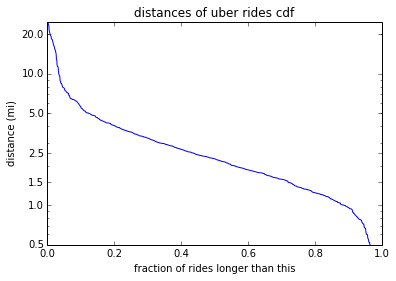

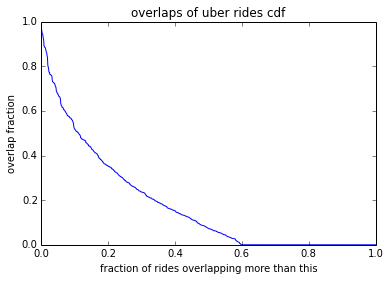

In [3]:
main()

# Data Time Range

In [4]:
allData = pd.read_csv("gpsdata/all.tsv", delimiter='\t', names = ['driver', 'time', 'lat', 'lng'], header = None)
allData.time = pd.to_datetime(allData.time)

In [5]:
print "Starting time " + str(np.min(allData.time))
print "End time " + str(np.max(allData.time))

Starting time 2007-01-01 00:00:00
End time 2007-01-07 23:59:58


# Pickup vs. Time

In [6]:
sfLat = [37.702154, 37.814454]
sfLng = [-122.520043, -122.352673]


def setupOD(df):
    return pd.Series({'pickupLat':df.iloc[0].lat,
                      'pickupLng':df.iloc[0].lng,
                      'dropoffLat':df.iloc[-1].lat,
                      'dropoffLng':df.iloc[-1].lng,
                      'pickupInSF':inSf(df.iloc[0]),
                      'dropoffInSF':inSf(df.iloc[-1]),
                      'pickupHour':calcHour(df.iloc[0]),
                      'dropoffHour':calcHour(df.iloc[-1]),
                      'duration':rideDuration(df)})

def inSf(df):
    return df.lat > sfLat[0] and df.lat < sfLat[1] and df.lng > sfLng[0] and df.lng < sfLng[1] 

def calcHour(df):
    # Calculate hours staring from 1/1/2007 midnight
    return (df.time.date().day - 1)  * 24 + df.time.hour

def rideDuration(df):
    return (df.iloc[-1].time - df.iloc[0].time).seconds / 60.0

In [7]:
ODdf = allData.groupby('driver').apply(setupOD)

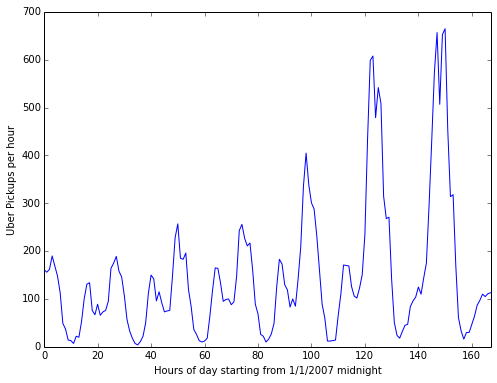

In [8]:
ODdf.groupby('pickupHour').size().plot(figsize=(8, 6))
plt.xlabel('Hours of day starting from 1/1/2007 midnight')
plt.ylabel('Uber Pickups per hour')
# x = np.linspace(0, 168, 7*4 + 1)
# plt.xticks(x, (x%24).astype(int), rotation='vertical')

# Duration

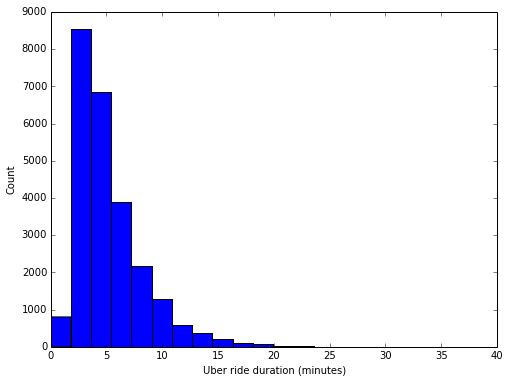

In [11]:
ODdf[ODdf.duration < 40].duration.plot(kind = 'hist', bins=20, figsize=(8, 6))
plt.xlabel('Uber ride duration (minutes)')
plt.ylabel('Count')